# Multi-Armed Bandits

In [297]:
# Imports
%matplotlib inline

import sys
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from random import gauss
from numpy.random import standard_normal
from scipy.special import erf
import math
from scipy.stats import norm
import random
from scipy.stats import bernoulli
import scipy.fftpack
from IPython import display

sns.set_style('darkgrid')
np.random.seed(0)
#

# Set-up

## Create an arm

**Create an arm**

In [52]:
""" Base class for an arm class."""

class Arm(object):
    """ Base class for an arm class."""
    
    def __init__(self, lower=0., amplitude=1.):
        """ Base class for an arm class."""
        self.lower = lower  #: Lower value of rewards
        self.amplitude = amplitude  #: Amplitude of value of rewards
        self.min = lower  #: Lower value of rewards
        self.max = lower + amplitude  #: Higher value of rewards

    # make this an attribute
    @property
    def lower_amplitude(self):
        """(lower, amplitude)"""
        if hasattr(self, 'lower') and hasattr(self, 'amplitude'):
            return self.lower, self.amplitude
        elif hasattr(self, 'min') and hasattr(self, 'max'):
            return self.min, self.max - self.min
        else:
            raise NotImplementedError("This method lower_amplitude() has to be implemented in the class inheriting from Arm.")

                                      
    def __str__(self):
        return self.__class__.__name__

    def __repr__(self):
        return "{}({})".format(self.__class__.__name__, self.__dir__)

                                      
                                      
    #### Random samples

    def draw(self, t=None):
        """ Draw one random sample."""
        raise NotImplementedError("This method draw(t) has to be implemented in the class inheriting from Arm.")

    def draw_nparray(self, shape=(1,)):
        """ Draw a numpy array of random samples, of a certain shape."""
        raise NotImplementedError("This method draw_nparray(t) has to be implemented in the class inheriting from Arm.")

                                      
                                      
    #### Lower bound

    @staticmethod
    def kl(x, y):
        """ The kl(x, y) to use for this arm."""
        raise NotImplementedError("This method kl(x, y) has to be implemented in the class inheriting from Arm.")

    @staticmethod
    def oneLR(mumax, mu):
        """ One term of the Lai & Robbins lower bound for Gaussian arms: (mumax - mu) / KL(mu, mumax). """
        raise NotImplementedError("This method oneLR(mumax, mu) has to be implemented in the class inheriting from Arm.")

    @staticmethod
    def oneHOI(mumax, mu):
        """ One term for the HOI factor for this arm."""
        return 1 - (mumax - mu)

**Create an arm with a Gaussian distribution**

In [53]:
oo = float('+inf') #+infinity

#: Default value for the variance of a [0, 1] Gaussian arm
VARIANCE = 0.05

In [54]:
class Gaussian(Arm):
    """
    Gaussian distributed arm, possibly truncated.
    Default is to truncate into [0, 1] (so Gaussian.draw() is in [0, 1]).
    """

    def __init__(self, mu, sigma=VARIANCE, mini=0, maxi=1):
        """New arm."""
        self.mu = self.mean = mu  #: Mean of Gaussian arm
        assert sigma > 0, "Error, the parameter 'sigma' for Gaussian arm has to be > 0."
        self.sigma = sigma  #: Variance of Gaussian arm
        assert mini <= maxi, "Error, the parameter 'mini' for Gaussian arm has to < 'maxi'."  # DEBUG
        self.min = mini  #: Lower value of rewards
        self.max = maxi  #: Higher value of rewards
        real_mean = mu + sigma * (phi(mini) - phi(maxi)) / (Phi(maxi) - Phi(mini))

        
    #### Random samples

    def draw(self, t=None):
        """ Draw one random sample. The parameter t is ignored in this Arm."""
        return min(max(gauss(self.mu, self.sigma), self.min), self.max)

    def draw_nparray(self, shape=(1,)):
        """ Draw a numpy array of random samples, of a certain shape."""
        return np.minimum(np.maximum(self.mu + self.sigma * standard_normal(shape), self.min), self.max)

    
    #### Printing

    # This decorator @property makes this method an attribute, cf. https://docs.python.org/3/library/functions.html#property
    @property
    def lower_amplitude(self):
        """(lower, amplitude)"""
        return self.min, self.max - self.min

    def __str__(self):
        return "Gaussian"

    def __repr__(self):
        return "N({:.3g}, {:.3g})".format(self.mu, self.sigma)

    
    #### Lower bound - NEED TO IMPLEMENT KULLBACK-LEIBLER DIVERGENCE FOR GAUSSIAN DISTRIBUTION FIRST
    if False:
        def kl(self, x, y):
            """ The kl(x, y) to use for this arm."""
            return klGauss(x, y, self.sigma)

        def oneLR(self, mumax, mu):
            """ One term of the Lai & Robbins lower bound for Gaussian arms: (mumax - mu) / KL(mu, mumax). """
            return (mumax - mu) / klGauss(mu, mumax, self.sigma)
    
    def oneHOI(self, mumax, mu):
        """ One term for the HOI factor for this arm."""
        return 1 - (mumax - mu) / self.max


class Gaussian_0_1(Gaussian):
    """ Gaussian distributed arm, truncated to [0, 1]."""
    def __init__(self, mu, sigma=0.05, mini=0, maxi=1):
        super(Gaussian_0_1, self).__init__(mu, sigma=sigma, mini=mini, maxi=maxi)



#: Default value for the variance of an unbounded Gaussian arm
UNBOUNDED_VARIANCE = 1


class UnboundedGaussian(Gaussian):
    """ Gaussian distributed arm, not truncated, ie. supported in (-oo,  oo)."""

    def __init__(self, mu, sigma=UNBOUNDED_VARIANCE):
        """New arm."""
        super(UnboundedGaussian, self).__init__(mu, sigma=sigma, mini=-oo, maxi=oo)

    def __str__(self):
        return "UnboundedGaussian"

    #### Random samples

    def draw(self, t=None):
        """ Draw one random sample. The parameter t is ignored in this Arm."""
        return gauss(self.mu, self.sigma)

    def draw_nparray(self, shape=(1,)):
        """ Draw a numpy array of random samples, of a certain shape."""
        return self.mu + self.sigma * standard_normal(shape)

    def __repr__(self):
        return "N({:.3g}, {:.3g})".format(self.mu, self.sigma)


    
def phi(xi):
    """
    the probability density function of the standard normal distribution
    """
    return np.exp(- 0.5 * xi**2) / np.sqrt(2. * np.pi)


def Phi(x):
    """
    It is the probability density function of the standard normal distribution
    """
    return (1. + erf(x / np.sqrt(2.))) / 2.
    
    
# Only export and expose the classes defined here
__all__ = [
    "Gaussian",
    "Gaussian_0_1",
    "UnboundedGaussian"
]


#### Debugging

if __name__ == "__main__":
    # Code for debugging purposes.
    from doctest import testmod
    print("\nTesting automatically all the docstring written in each functions of this module :")
    testmod(verbose=True)


Testing automatically all the docstring written in each functions of this module :
32 items had no tests:
    __main__
    __main__.Arm
    __main__.Arm.__init__
    __main__.Arm.__repr__
    __main__.Arm.__str__
    __main__.Arm.draw
    __main__.Arm.draw_nparray
    __main__.Arm.kl
    __main__.Arm.lower_amplitude
    __main__.Arm.oneHOI
    __main__.Arm.oneLR
    __main__.Gaussian
    __main__.Gaussian.__init__
    __main__.Gaussian.__repr__
    __main__.Gaussian.__str__
    __main__.Gaussian.draw
    __main__.Gaussian.draw_nparray
    __main__.Gaussian.lower_amplitude
    __main__.Gaussian.oneHOI
    __main__.Gaussian_0_1
    __main__.Gaussian_0_1.__init__
    __main__.Phi
    __main__.UnboundedGaussian
    __main__.UnboundedGaussian.__init__
    __main__.UnboundedGaussian.__repr__
    __main__.UnboundedGaussian.__str__
    __main__.UnboundedGaussian.draw
    __main__.UnboundedGaussian.draw_nparray
    __main__.fftind
    __main__.gaussian_random_field
    __main__.phi
    __main_

In [55]:
random.seed(0); np.random.seed(0)

my_arm = Arm()



my_gaussian = Gaussian(0.3,0.5)

for i in range(10):
    print (gauss(0.3,0.5))
    
l = [gauss(random.random(),0.5) for i in range(10)]

print (l)

0.7708577023403322
-0.39828905235057493
-0.03985722403921055
0.4852517837303299
-0.2081744470940355
0.2639399886074643
0.38959824363742845
-0.1155496076354941
-0.35451868222967936
0.39694387062455205
[0.5014355699897972, 0.7438247514842861, 0.6148801905246768, 2.0793952183745663, 1.1622029801807736, 0.4813466937549, 0.6710584895506947, -0.41658113896077986, -0.4132935713546396, 0.25752986074332074]


In [56]:
gaus01 = Gaussian_0_1(0.5,0.2)

l = [Gaussian_0_1(random.random()) for i in range(10)]

print (l)


[N(0.477, 0.05), N(0.865, 0.05), N(0.26, 0.05), N(0.805, 0.05), N(0.549, 0.05), N(0.014, 0.05), N(0.72, 0.05), N(0.399, 0.05), N(0.825, 0.05), N(0.668, 0.05)]


# Implementing policies

See https://arxiv.org/pdf/1307.6134.pdf, page 22 and 23

** Deterministic UCL algorithm**

In [280]:
def deterministic_ucl(prior_means,prior_variance,variance,n_arms,time_horizon,arms,random_rewards=True):
    """
    Inputs: 
    prior_means - an array of prior means about the pay-offs of the arms
    prior_variance - prior variance characterising the prior Gaussian distribution, constant for all arms
    variance - variance of Gaussian distributions of each arm, constant for all arms, assumed known before the game begins
    n_arms - number of arms of the MAB
    time_horizon - number of time steps of the game
    arms - a list or array of arms together with their reward distribution
    
    Output : allocation sequence of arms over the time horizon
    """
    
    #### Initialisation
    
    # n[i] denotes the number of pulls of the arm i in t-1 peridos
    n = np.zeros(n_arms)
    
    # m_bar[i] denotes the mean pay-off as observed in t-1 periods
    m_bar = np.zeros(n_arms)
    
    # normalise variance
    delta_sq = variance / prior_variance
    
    # K is a tuner variable
    K = math.sqrt(2*math.pi*math.e)
    
    # rewards array
    rewards = np.zeros(time_horizon)
    
    # allocation sequence (output)
    alloc_seq = np.zeros(time_horizon)
    
    # initialise the values of the heuristic function for each arm
    Q = np.zeros(n_arms)
    
    #### Iteration
    # at each time pick the arm with maximum upper credible limit (UCL)
    for t in range(time_horizon):
        
        if random_rewards==True:
            # initialise a list of rewards
            all_rewards = [arms[i].draw() for i in range(n_arms)]
        else:
            all_rewards = arms
        
        for i in range(n_arms):
            # Compute a heuristic value for the current arm
            Q[i] = (delta_sq*prior_means[i]+n[i]*m_bar[i])/(delta_sq+n[i]) + (math.sqrt(variance/(delta_sq+n[i])))*norm.ppf(1-1/(K*(t+1)))
        
        #print("Q:",Q)
        #print('argmaxQ:',np.argmax(Q),'maxQ:',np.max(Q))
        
        # select an arm with the highest heuristic function value
        selected_arm = np.argmax(Q)
        alloc_seq[t] = selected_arm
        
        
        # collect reward m_real
        rewards[t] = all_rewards[selected_arm]
        
        #print ('all rewards:', all_rewards)
        
        # update variables
        m_bar[selected_arm] = (n[selected_arm]*m_bar[selected_arm] + all_rewards[selected_arm]) / (n[selected_arm] + 1)
        n[selected_arm] += 1
        
        #print ('m_bar:',m_bar)
        #print ('n:',n)
    
    return alloc_seq

In [244]:
priors = [random.random() for i in range(10)]
print(priors)
prior_var = 0.5
variance = 0.05
n = 10
T = 100
m = [i/10 for i in range(10)]


deterministic_ucl(priors,prior_var,variance,n,T,m,random_rewards=False)

[0.2267303068611829, 0.9884641913767884, 0.9320839704500764, 0.8607582358944526, 0.708660603904871, 0.25339362300409407, 0.9266405325433711, 0.8226150536819123, 0.6339284115538394, 0.17095267398225444]
Q: [ 0.72168904  1.48342292  1.4270427   1.35571697  1.20361934  0.74835235
  1.42159926  1.31757379  1.12888714  0.66591141]
argmaxQ: 1 maxQ: 1.48342292294
all rewards: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
m_bar: [ 0.   0.1  0.   0.   0.   0.   0.   0.   0.   0. ]
n: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Q: [ 1.05409839  0.43023033  1.75945205  1.68812631  1.53602868  1.0807617
  1.75400861  1.64998313  1.46129649  0.99832075]
argmaxQ: 2 maxQ: 1.75945204924
all rewards: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
m_bar: [ 0.   0.1  0.2  0.   0.   0.   0.   0.   0.   0. ]
n: [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
Q: [ 1.21715111  0.47939258  0.5651762   1.85117904  1.6990814   1.24381442
  1.91706133  1.81303585  1.62434921  1.16137347]
argmaxQ: 6 maxQ: 1.9170

array([ 1.,  2.,  6.,  3.,  7.,  4.,  8.,  5.,  0.,  9.,  9.,  8.,  9.,
        7.,  9.,  8.,  9.,  9.,  6.,  9.,  8.,  9.,  9.,  7.,  9.,  9.,
        8.,  9.,  9.,  9.,  9.,  8.,  9.,  9.,  9.,  9.,  9.,  8.,  7.,
        9.,  9.,  9.,  5.,  9.,  9.,  8.,  9.,  6.,  9.,  9.,  9.,  9.,
        9.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  7.,  9.,  4.,  8.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  7.,
        8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.])

**Stochastic UCL algorithm**

In [59]:
 def find_min_diff(arr, n): 
    """
    Returns minimum difference between any pair of elements in an array
    
    arr - numpy array
    n - number of elements in the array used in the process
    """
    
    # Sort array in non-decreasing order 
    arr = sorted(arr) 
  
    # Initialize difference as infinite 
    diff = 10**20
  
    # Find the min diff by comparing adjacent 
    # pairs in sorted array 
    for i in range(n-1): 
        if abs(arr[i+1] - arr[i]) < diff: 
            diff = abs(arr[i+1] - arr[i]) 
  
    # Return min diff 
    return diff

In [60]:
def stochastic_ucl(prior_means,prior_variance,variance,n_arms,time_horizon,arms):
    """
    Inputs: 
    prior_means - an array of prior means about the pay-offs of the arms
    prior_variance - prior variance characterising the prior Gaussian distribution, constant for all arms
    variance - variance of Gaussian distributions of each arm, constant for all arms, assumed known before the game begins
    n_arms - number of arms of the MAB
    time_horizon - number of time steps of the game
    arms - a list or array of arms together with their reward distribution
    
    Output : allocation sequence of arms over the time horizon
    """
    
    #### Initialisation
    
    # n[i] denotes the number of pulls of the arm i in t-1 peridos
    n = np.zeros(n_arms)
    
    # m_bar[i] denotes the mean pay-off as observed in t-1 periods
    m_bar = np.zeros(n_arms)
    
    # normalise variance
    delta_sq = variance / prior_variance
    
    # K is a tuner variable
    K = math.sqrt(2*math.pi*math.e)
    
    T_0_end = 0
    
    # rewards array
    rewards = np.zeros(time_horizon)
    
    # allocation sequence (output)
    alloc_seq = np.zeros(time_horizon)
    
    
    #### First arm
    
    # Pick the first arm based on the highest prior mean
    alloc_seq[0] = np.argmax(prior_means)
    
    # claim the reward from that arm
    # initialise a list of rewards
    all_rewards = [arms[i].draw() for i in range(n_arms)]
    rewards[0] = all_rewards[np.argmax(prior_means)]
    
    #### Iteration
    #  at each time pick an arm using Boltzmann probability distribution
    for t in range(1,time_horizon):
        
        # initialise the values of the heuristic function for each arm
        Q = np.zeros(n_arms)
        
        # initialise a list of rewards
        all_rewards = [arms[i].draw() for i in range(n_arms)]
        
        #print ("rewards:",all_rewards)
        
        for i in range(n_arms):
            
            # Compute a heuristic value for the current arm
            Q[i] = (delta_sq*prior_means[i]+n[i]*m_bar[i])/(delta_sq+n[i]) + math.sqrt(variance/(delta_sq+n[i]))*norm.ppf(1-1/(K*(t+1)))
        
        # find the minimum gap of the heuristic function value between any two arms
        delta_Q_min = find_min_diff(Q,n_arms)
        
        # define the cooling schedule
        v = delta_Q_min/(2*math.log(t+1))
        
        # select an arm with the highest probability
        P = np.exp(Q/v)/np.sum(np.exp(Q/v))
        
        """print("Q:",Q)
        print("v:",v)
        print ("P:",P)"""
        
        selected_arm = np.argmax(P)
        alloc_seq[t] = selected_arm
        
        # collect reward m_real
        rewards[t] = all_rewards[selected_arm]
        
        # update variables
        m_bar[selected_arm] = (n[selected_arm]*m_bar[selected_arm] + all_rewards[selected_arm]) / (n[selected_arm] + 1)
        n[selected_arm] += 1
    
    return alloc_seq

In [61]:
n = 10
priors = [random.random() for i in range(n)]
print (priors)
prior_var = 0.5
variance = 0.05
T = 10
m = [Gaussian_0_1(random.random(),variance) for i in range(n)]


stochastic_ucl(priors,prior_var,variance,n,T,m)

[0.47162541509628797, 0.40990539565755457, 0.5691127395242802, 0.5086001300626332, 0.3114460010002068, 0.35715168259026286, 0.837661174368979, 0.25093266482213705, 0.560600218853524, 0.012436318829314397]


array([ 6.,  6.,  2.,  8.,  3.,  0.,  1.,  5.,  4.,  0.])

In [62]:
a = np.array([1,2,3,4,5])
print (np.sum(a))

np.exp(a/2)/np.sum(np.exp(a/2))

15


array([ 0.05801222,  0.09564598,  0.15769356,  0.25999272,  0.42865553])

**Block UCL algorithm**

See also http://www.princeton.edu/~naomi/publications/2013/Allerton2013ol.pdf for modelling bandits as a foraging problem

In [70]:
def block_ucl(prior_means,prior_variance,variance,n_arms,time_horizon, arms, random_rewards = True):
    """
    Inputs: 
    prior_means - an array of prior means about the pay-offs of the arms
    prior_variance - prior variance characterising the prior Gaussian distribution, constant for all arms
    variance - variance of Gaussian distributions of each arm, constant for all arms, assumed known before the game begins
    n_arms - number of arms of the MAB
    time_horizon - number of time steps of the game
    arms - set of arms, either input as a probability distribtion (Gaussian) or as an array of pay-offs for each arm
    random_rewards - True if the rewards are drawn i.i.d. from Gaussian distribution at each time step
    
    Output : allocation sequence of arms over the time horizon
    """
    
    
    #### Initialisation
    
    # n[i] denotes the number of pulls of the arm i in t-1 peridos
    n = np.zeros(n_arms)
    
    # m_bar[i] denotes the mean pay-off as observed in t-1 periods
    m_bar = np.zeros(n_arms)
    
    # normalise variance
    delta_sq = variance / prior_variance
    
    # K is a tuner variable
    K = math.sqrt(2*math.pi*math.e)
    
    # rewards array
    rewards = np.zeros(time_horizon)
    
    # allocation sequence (output)
    alloc_seq = np.zeros(time_horizon)
    
    # initialise the values of the heuristic function for each arm
    Q = np.zeros(n_arms)
    
    
    #### Iteration
    # at each allocation round pick the arm with maximum upper credible limit
    
    # let l be the smallest index s.t. T<2^l
    l = math.ceil(math.exp(math.log(T)/2))
    
    
    for k in range(1,l+1):
        
        # let bk be the total number of blocks in frame fk:
        bk = math.ceil((2**(k-1))/k)
        
        for r in range(1,bk+1):
            tau = 2**(k-1) + (r-1)*k
            
            for i in range(n_arms):
                # Compute a heuristic value for the current arm
                Q[i] = (delta_sq*prior_means[i]+n[i]*m_bar[i])/(delta_sq+n[i]) + math.sqrt(variance/(delta_sq+n[i]))*norm.ppf(1-1/(K*(tau)))
            
            # select an arm with the maximum value of the heuristic function
            i_hat = np.argmax(Q)
            
            #print (k,tau,2**(k)-tau)
            
            if 2**(k)-tau >= k:
                
                #print ("1")
                
                # select the same arm for the whole duration of the block
                for t in range(tau,tau+k):
                    
                    # terminate the algorithm and return the allocation sequence if the we are past the last time step
                    if t-1>=time_horizon:
                        return alloc_seq
                    
                    #print("if",t-1)
                    
                    if random_rewards == True:
                        # initialise a list of rewards
                        all_rewards = [arms[i].draw() for i in range(n_arms)]
                    else:
                        all_rewards = arms
                    
                    alloc_seq[t-1] = i_hat
                
                    #collect reward
                    rewards[t-1] = all_rewards[i_hat]
                    
                    # update variables
                    m_bar[i_hat] = (n[i_hat]*m_bar[i_hat]+all_rewards[i_hat])/(n[i_hat]+1)
                    n[i_hat] +=1
                    
            else:
                
                #print ("2")
                
                
                for t in range(tau,2**(k)):
                    
                    # terminate the algorithm and return the allocation sequence if the we are past the last time step
                    if t-1>=time_horizon:
                        return alloc_seq
                    
                    #print("else",t-1)
                    
                    if random_rewards == True:
                        # initialise a list of rewards
                        all_rewards = [arms[i].draw() for i in range(n_arms)]
                    else:
                        all_rewards = arms
                    
                    
                    alloc_seq[t-1] = i_hat
                
                    #colect reward
                    rewards[t-1] = all_rewards[i_hat]
                    
                    # update variables
                    m_bar[i_hat] = (n[i_hat]*m_bar[i_hat]+all_rewards[i_hat])/(n[i_hat]+1)
                    n[i_hat] +=1
                    
    return alloc_seq                

In [233]:
n = 10
priors = [1 for i in range(n)]
prior_var = 10**30
variance = 0.05
T = 10
m = [i for i in range(n)]
print (m)


block_ucl(priors,prior_var,variance,n,T,m,random_rewards=False)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


array([ 0.,  1.,  1.,  2.,  2.,  2.,  3.,  4.,  4.,  4.])

## Other algorithms

**Thompson Sampling**

See https://courses.cs.washington.edu/courses/cse599i/18wi/resources/lecture3/lecture3.pdf, page 13

In [320]:
def thompson(n_arms,time_horizon,arms=[],random_rewards=True):
    """
    Inputs:
    Arms 1 through n_arms, max steps time_horzin
    """
    
    #### Initialisation
    # S[i] denotes the number of successes of arm i so far
    S = np.zeros(n_arms)
    
    # F[i] denotes the number of failures of arm i so far
    F = np.zeros(n_arms)
    
    # T[i] denotes the total number of plays of arm i so far
    T = np.zeros(n_arms)
    
    # rewards array
    rewards = np.zeros(time_horizon)
    
    # allocation sequence (output)
    alloc_seq = np.zeros(time_horizon)
    
    
    #### Iteration
    for t in range(time_horizon):
        # Draw each \mu_i according to the posterior distribution
        mu = np.random.beta(1+S, 1+F)
        # play an arm according to the probability of its mean being the largest
        play = np.argmax(mu)
        alloc_seq[t] = play
        
        # Increment the total counter for the played arms
        T[play] += 1
        
        if random_rewards:
            # Observe reward
            r = bernoulli.rvs(mu[play])
            rewards[t] = r
        else:
            # get reward from arms
            rewards[t] = arms[play]

        # Update success counter appropriately
        S[play] += 1
        
        # Update failure counter appropriately
        F[play] += 1
        
    return alloc_seq

In [317]:
theta = np.random.beta(1, 1,10)

print (theta)

bernoulli.rvs(0.7)

thompson(10,10)

[ 0.54865001  0.48986674  0.74590334  0.52321749  0.96012512  0.80605068
  0.36495428  0.86849538  0.14865332  0.86763263]


array([ 7.,  7.,  3.,  5.,  6.,  4.,  4.,  5.,  2.,  3.])

# Gaussian random fields

## Discrete Gaussian random field

In [67]:
def fftind(size):
    """ Returns a numpy array of shifted Fourier coordinates k_x k_y.
        
        Input:
        size (integer): The size of the coordinate array to create
        
        Output:
            k_ind, numpy array of shape (2, size, size) with:
                k_ind[0,:,:]:  k_x components
                k_ind[1,:,:]:  k_y components
    """
    k_ind = np.mgrid[:size, :size] - int( (size + 1)/2 )
    k_ind = scipy.fftpack.fftshift(k_ind)
    return( k_ind )

In [68]:
def gaussian_random_field(alpha = 3.0, size = 128, flag_normalize = True):
    """ 
    Returns a numpy array of sizexsize discrete Gaussian random field
        
    Input:
    alpha (double, default = 3.0): 
        The power of the power-law momentum distribution
    size (integer, default = 128):
        The size of the square output Gaussian Random Fields
    flag_normalize (boolean, default = True):
        Normalizes the Gaussian Field:
            - to have an average of 0.0
            - to have a standard deviation of 1.0
    Output:
    gfield (numpy array of shape (size, size)):
        The random gaussian random field

    Example:
    import matplotlib
    import matplotlib.pyplot as plt
    example = gaussian_random_field()
    plt.imshow(example)
    """
        
        # Defines momentum indices
    k_idx = fftind(size)

        # Defines the amplitude as a power law 1/|k|^(alpha/2)
    amplitude = np.power( k_idx[0]**2 + k_idx[1]**2 + 1e-10, -alpha/4.0 )
    amplitude[0,0] = 0
    
        # Draws a complex gaussian random noise with normal
        # (circular) distribution
    noise = np.random.normal(size = (size, size)) \
        + 1j * np.random.normal(size = (size, size))
    
        # To real space
    gfield = np.fft.ifft2(noise * amplitude).real
    
        # Sets the standard deviation to one
    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = gfield/np.std(gfield)
        
    return gfield


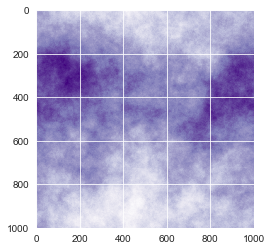

Text(0.5,1,'Profiles')

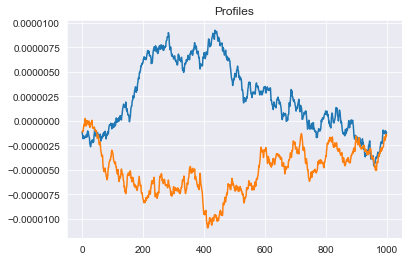

In [339]:
example = gaussian_random_field(size = 1000, flag_normalize = False)
plt.imshow(example, cmap='Purples')
plt.show()
plt.plot(example[:,0])
plt.plot(example[0,:])
plt.title('Profiles')

## Continuous Gaussian random field

In [337]:
import gaussian_random_field

ImportError: No module named 'gaussian_random_field'

# Single agent in a static discrete random field

In [ ]:
Simple simulations: a single agent is places in an environment with unlimited movement

Place an $n$-armed bandit into a $\sqrt{n} \sqrt{n}$ Gaussian random field, where each cell in the grid corresponds to an arm. The pay-off is determined by the underlying random field

**Determinstic algorithm**

In [181]:
def field_to_arms(rand_field):
    """
    transforms an nxn grid generated as a random field to set of n^2 arms
    
    rand_field - Gaussian random field
    """
    return rand_field.ravel()

In [303]:
def arms_to_field(arms,n):
    """
    Transforms an allocation sequence to sequence of 2D coordinates in the same structure as the field
    
    arms - an allocation sequence
    """
    return arms%n,arms//n 
    

In [182]:
field_to_arms(example)

array([-0.0255534 ,  0.00330692, -0.00195368, -0.02635594, -0.02646589,
       -0.02528065, -0.01666669, -0.02405314, -0.03633778, -0.02008779,
        0.00896994,  0.01559294,  0.00265515, -0.04109528, -0.0526478 ,
       -0.02942347, -0.00437601, -0.01230224,  0.00596488,  0.03264737,
        0.03374268,  0.01520349,  0.00284715, -0.03200421, -0.02883378,
       -0.02605196, -0.00810157, -0.00795971,  0.03066385,  0.03278083,
       -0.01984957, -0.00536542,  0.00707734,  0.00449407,  0.01686475,
        0.00556161,  0.01010788,  0.00424495,  0.00490529,  0.0012753 ,
       -0.01818378,  0.01080331,  0.02628242,  0.05281121,  0.05356537,
        0.05944666,  0.0280091 ,  0.02229251, -0.01432774, -0.02007716,
        0.01585828,  0.03257648,  0.04641218,  0.04622255,  0.06909221,
        0.08061609,  0.00926008, -0.02514465, -0.01966272, -0.01211978,
        0.00580622,  0.01030631,  0.00327452,  0.02709181,  0.06562556,
        0.07558737,  0.02556102, -0.01441646, -0.05158084, -0.02

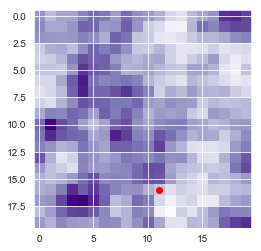

In [329]:
### Create an animation with a single bandit

# retreive a Gaussian random field
field = gaussian_random_field(size = 20, flag_normalize = True)
plt.imshow(field, cmap='Purples')

n = 400
priors = [random.random() for i in range(n)]
print (np.argmax(priors))
prior_var = 10*30 # uninformative priors has variance -> infinity
variance = 1
T = 100
m = field_to_arms(field)
# print (np.argmax(m),np.max(m))
# print (m)

result = arms_to_field(deterministic_ucl(priors,prior_var,variance,n,T,m,random_rewards=False),20)

#print (arms_to_field(result)[0][2])

# plt.scatter(arms_to_field(result)[0],arms_to_field(result)[1])

for l in range(100):
    plt.clf()
    plt.imshow(field, cmap='Purples')
    plt.scatter(result[0][l],result[1][l],color='r')
    #plt.show()
    display.display(plt.gcf())
    display.clear_output(wait=True)

**Stochastic algortithm: Thompson sampling**

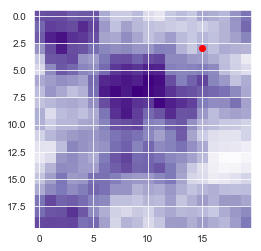

In [340]:
### Create an animation with a single bandit

# retreive a Gaussian random field
field = gaussian_random_field(size = 20, flag_normalize = True)
plt.imshow(field, cmap='Purples')

n = 400
priors = [random.random() for i in range(n)]
print (np.argmax(priors))
prior_var = 1 # uninformative priors has variance -> infinity
variance = 1
T = 100
m = field_to_arms(field)
# print (np.argmax(m),np.max(m))
# print (m)

result = arms_to_field(thompson(n,T,arms=m,random_rewards=False),20)

#print (arms_to_field(result)[0][2])

# plt.scatter(arms_to_field(result)[0],arms_to_field(result)[1])

for l in range(100):
    plt.clf()
    plt.imshow(field, cmap='Purples')
    plt.scatter(result[0][l],result[1][l],color='r')
    #plt.show()
    display.display(plt.gcf())
    display.clear_output(wait=True)

**Block algorithm**

Exploration incurs positive transition cost. We assume that the agent can access every arm.

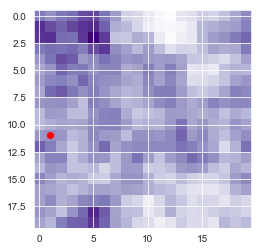

In [330]:
### Create an animation with a single bandit

# retreive a Gaussian random field
field = gaussian_random_field(size = 20, flag_normalize = True)
plt.imshow(field, cmap='Purples')

n = 400
priors = [random.random() for i in range(n)]
print (np.argmax(priors))
prior_var = 10*30 # uninformative priors has variance -> infinity
variance = 1
T = 100
m = field_to_arms(field)
# print (np.argmax(m),np.max(m))
# print (m)

result = arms_to_field(block_ucl(priors,prior_var,variance,n,T,m,random_rewards=False),20)

#print (arms_to_field(result)[0][2])

# plt.scatter(arms_to_field(result)[0],arms_to_field(result)[1])

for l in range(100):
    plt.clf()
    plt.imshow(field, cmap='Purples')
    plt.scatter(result[0][l],result[1][l],color='r')
    #plt.show()
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Multiple agents in a static discrete random field

Next, we will consider multiple agents in a Gaussian random field moving freely - there are no restrictions on where they can move. Multiple agents can occupy the same cell in the grid. All agents have random priors, so there is no prior informational advantage.

**Block UCL algorithm**

In [342]:
def single_agent_moving(n_arms,time_horizon,gauss_field):
    """
    Creates a simulation of single agents moving in a static Gaussian random field
    
    Inputs:
    n_arms - number of arms of the MAB. Same MAB for every agent
    time_horizon - total amount of time steps
    gauss_field - Gaussian random field
    """
    
    #CHANGE PRIORS
    
    priors = field_to_arms(gauss_field)
    prior_var = 10*30 # uninformative priors have variance -> infinity
    variance = 1
    m = field_to_arms(gauss_field)
    
    return arms_to_field(block_ucl(priors,prior_var,variance,n_arms,time_horizon,m,random_rewards=False),math.sqrt(n_arms))


In [343]:
def mult_agents_moving(n_agents,n_arms,time_horizon,gauss_field):
    """
    Creates a simulation of multiple agents moving in a static Gaussian random field
    
    Inputs:
    n_agents - number of agents
    n_arms - number of arms of the MAB. Same MAB for every agent
    time_horizon - total amount of time steps
    gauss_field - Gaussian random field
    """
    for l in range(time_horizon):
        plt.clf()
        plt.imshow(gauss_field, cmap='Purples')
        for i in range(n_agents):
            result = single_agent_moving(n_arms,time_horizon,gauss_field)
            plt.scatter(result[0][l],result[1][l],color='r')
        #plt.show()
        display.display(plt.gcf())
        display.clear_output(wait=True)


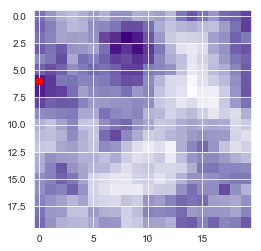

In [344]:
field = gaussian_random_field(size = 20, flag_normalize = True)

mult_agents_moving(10,400,10,field)

# Single agent in a dynamic discrete random field

In [349]:
def single_agent_dynamic_field(n_arms,time_horizon,gauss_field,m_steps):
    """
    Creates a simulation of single agents moving in a dynamic Gaussian random field
    
    Inputs:
    n_arms - number of arms of the MAB. Same MAB for every agent
    time_horizon - total amount of time steps
    gauss_field - initial Gaussian random field
    m_steps - number of time steps after which the program generates a new Gaussian random field
    """
    
    priors = field_to_arms(gauss_field)
    prior_var = 10*30 # uninformative priors have variance -> infinity
    variance = 1
    m = field_to_arms(gauss_field)
    
    for l in range(time_horizon):
        plt.clf()
        
        ## change the field every m_steps
        if l % m_steps == 0:
            field = gaussian_random_field(size = 20, flag_normalize = True)
            
        plt.imshow(field, cmap='Purples')
        m = field_to_arms(field)
        result = arms_to_field(block_ucl(priors,prior_var,variance,n_arms,time_horizon,m,random_rewards=False),math.sqrt(n_arms))
        plt.scatter(result[0][l],result[1][l],color='r')
        #plt.show()
        display.display(plt.gcf())
        display.clear_output(wait=True)

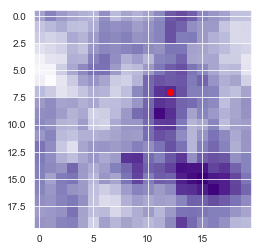

In [352]:
single_agent_dynamic_field(400,100,gaussian_random_field(size = 20, flag_normalize = True),4)